# 2) 코스피 절대모멘텀 전략

In [2]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index

    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        if(netCumReturn.iloc[-1].sum() ==0):
            totalAsset =1
        else:
            totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


In [4]:
kodex200 =getCloseData("069500","2012","2022-10-31") 
kodex5Bond = getCloseData("114470", "2012", "2022-9-30") 

closeDataSet = pd.concat([kodex200, kodex5Bond], axis=1)
closeDataSet.columns = ['kodex200','kodex5Bond']
closeDataSet.dropna(inplace=True)
closeDataSet

,kodex200,kodex5Bond
Date,,
2012-01-02,20150,86359.0
2012-01-03,20783,86338.0
2012-01-04,20665,86338.0
2012-01-05,20630,86334.0
2012-01-06,20339,86384.0
...,...,...
2022-09-26,28948,104820.0
2022-09-27,29003,104895.0
2022-09-28,28291,104920.0


In [5]:
rebalDate = getRebalancingDate(closeDataSet)
priceOnRebalDate = closeDataSet.loc[rebalDate]
priceOnRebalDate

,kodex200,kodex5Bond
Date,,
2012-01-31,21668,86498.0
2012-02-29,22476,86614.0
2012-03-30,22437,86581.0
2012-04-30,22316,87102.0
2012-05-31,20585,87668.0
...,...,...
2022-05-31,35239,107569.0
2022-06-30,30700,106387.0
2022-07-29,32272,108419.0


In [6]:
weight = priceOnRebalDate.copy()
weight['mthavg'] = (weight['kodex200'].shift(1)+weight['kodex200'].shift(2)+weight['kodex200'].shift(3)+weight['kodex200'].shift(4)+weight['kodex200'].shift(5)+weight['kodex200'].shift(6)+weight['kodex200'].shift(7)+weight['kodex200'].shift(8)+weight['kodex200'].shift(9)+weight['kodex200'].shift(10))/10
weight['weight_kodex200'] = np.where(weight['kodex200'] > weight['mthavg'], 1,0)
weight['weight_kodex5Bond'] = np.where(weight['kodex200'] < weight['mthavg'], 1,0)

weight = weight.drop(['kodex200','kodex5Bond','mthavg'], axis=1)
weight.columns= ['kodex200','kodex5Bond']

In [7]:
weight

,kodex200,kodex5Bond
Date,,
2012-01-31,0,0
2012-02-29,0,0
2012-03-30,0,0
2012-04-30,0,0
2012-05-31,0,0
...,...,...
2022-05-31,0,1
2022-06-30,0,1
2022-07-29,0,1


In [8]:
_, CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight)
cagr, dd, mdd = getEvaluation(CumReturn)

최종 수익률: 4.023738255851328
cagr: 1.1428209482497897
mdd: 9.51807620969053


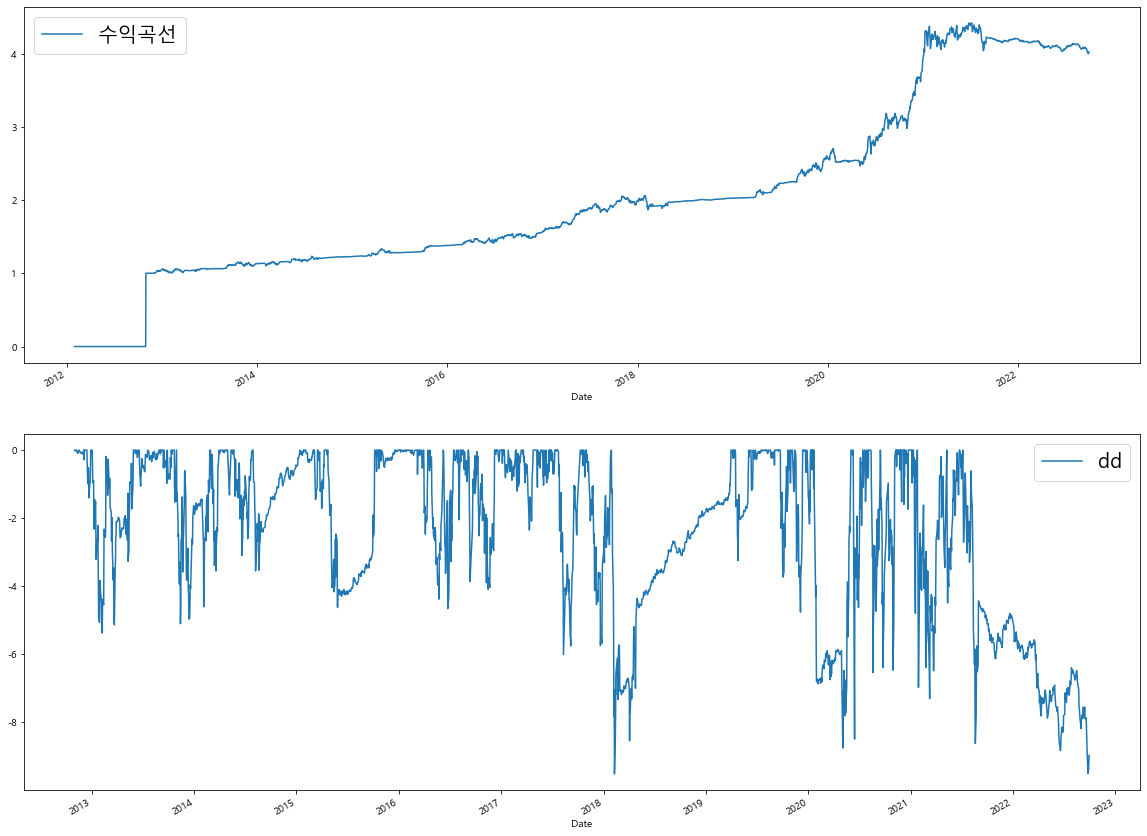

In [9]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
CumReturn.plot(label="수익곡선")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd).plot(label="dd")
plt.legend(fontsize=20)

plt.show()